# This notebook presents some analysis and results using Football Tracking and Event data provided by Metrica Sports.

Furthermore, I present my own solutions to the challenges proposed by Laurie Shaw in https://www.youtube.com/watch?v=5X1cSehLg6s.

As basis, I adapted the base code from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking. The data was extracted from https://github.com/metrica-sports/sample-data.



In [2]:
import LaurieOnTracking_SourceCode.Metrica_IO as mio
import LaurieOnTracking_SourceCode.Metrica_Viz as mviz
import LaurieOnTracking_SourceCode.Metrica_Velocities as mvel
import LaurieOnTracking_SourceCode.Metrica_PitchControl as mpc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [ ]:

DATADIR = 'metrica_sample_data/data'
game_id = 2

# EVENT DATA
events = mio.read_event_data(DATADIR,game_id)
events = mio.to_metric_coordinates(events)


# TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

In [16]:
def get_initial_pass(ind):
    
    team_event = events.loc[ind].Team
    counter = 0

    while team_event == events.loc[ind].Team:
        counter += 1
        team_event = events.loc[ind-counter].Team
        
    play = events.iloc[ind-counter:ind]
        
    return play[play['Type'].isin(['PASS', 'SHOT'])]

**Plot Pitch Control for the third Goal**

Third Goal Sequence:


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1109,Home,PASS,NaN,2,73621,2944.84,73649,2945.96,Player6,Player5,20.14,0.68,4.24,-4.08
1110,Home,PASS,NaN,2,73692,2947.68,73731,2949.24,Player5,Player8,-4.24,-6.12,-11.66,-25.84
1111,Home,PASS,NaN,2,73813,2952.52,73844,2953.76,Player8,Player9,-27.56,-21.08,-36.04,-4.08
1115,Home,PASS,NaN,2,73902,2956.08,73923,2956.92,Player10,Player8,-39.22,-8.16,-43.46,-19.04
1116,Home,PASS,CROSS,2,73955,2958.20,73983,2959.32,Player8,Player9,-46.64,-19.72,-47.70,1.36


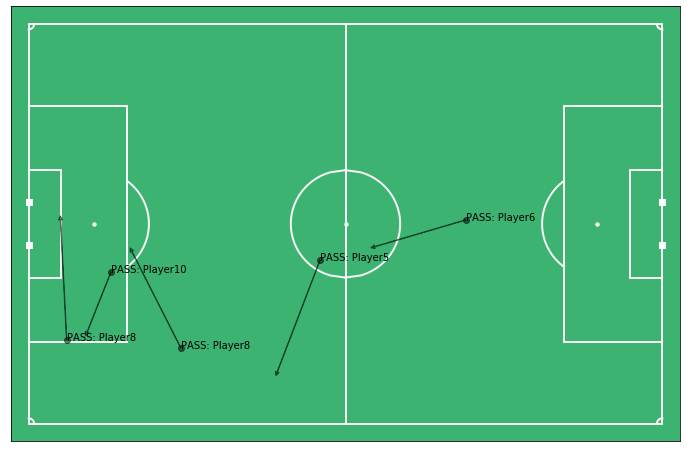

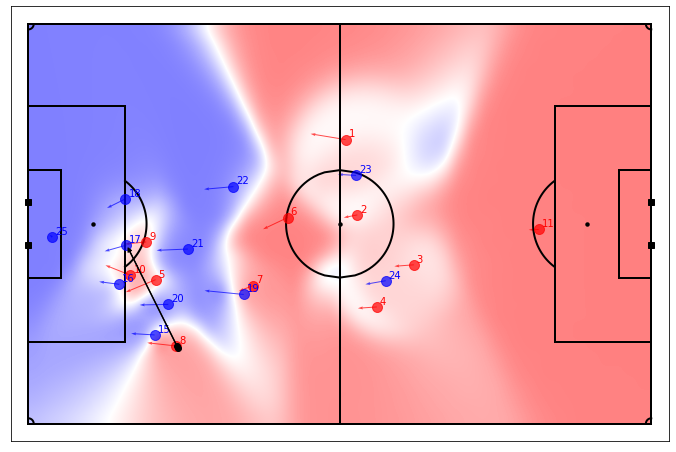

In [28]:
#code from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py


# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()


#THIRD GOAL
print('Third Goal Sequence:')
ind = goals.iloc[2].name
third_goal = get_initial_pass(ind)

display(third_goal)
mviz.plot_events( third_goal, color='k', indicators = ['Marker','Arrow'], annotate=True )


#PITCH CONTROL
# first get pitch control model parameters
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

# evaluated pitch control surface for specific pass
n_pass = 2
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(third_goal.iloc[n_pass].name, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( third_goal.iloc[n_pass].name, events,  tracking_home, tracking_away, PPCF, annotate=True )


plt.show()

**Problem 1: Compute probability of the occurence of the Third goal (as a sequence of specific passes)**

[(1109, 0.8294118039479079),
 (1110, 0.8847004936844359),
 (1111, 0.6008328797330316),
 (1115, 0.9767710585103276),
 (1116, 0.1613295457364334)]

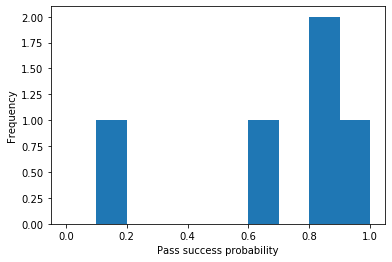

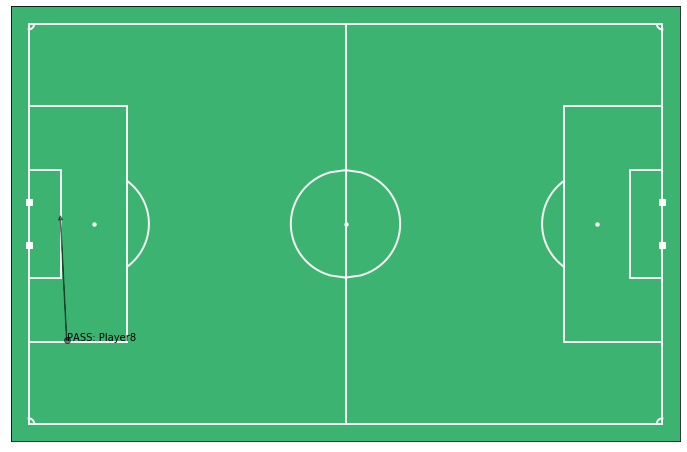

In [31]:

# list for pass probablities
pass_success_probability = []

for i,row in third_goal.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )
    
display(pass_success_probability)

fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes
risky_pass_prob = 0.5
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1] < risky_pass_prob ] ]

# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

plt.show()

Overall, we can see that the probabilities of the passes that lead to the third goal were higher (greater than 0.6), except a specific pass (from Player 8 to Player 9). 

Indeed, this specific pass has a probability of success of only 0.16, this can be also concluded from the Figure on the section above (Pitch Control image) as, when Player 8 performs the pass, the area around Player 9 is mostly blue, which means that it might be intercept. 

But, as the pass was successful the play continued and resulted in a goal.


**Problem 2: Find the goal with higher probabilty of sucess**

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


1
Most Probable Goal: 1 goal


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


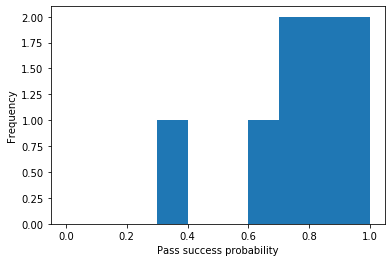

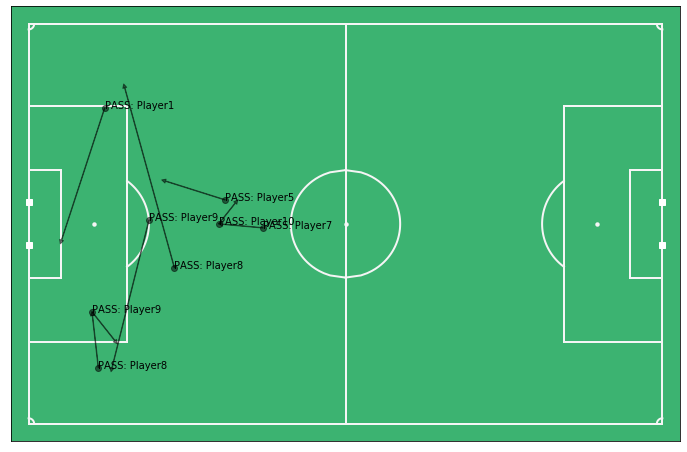

In [66]:

higher_prob = 0
pass_probabilities = []
new_ind = 1
counter = 1

display(goals)

for ind, g_row in goals.iterrows():
    goal_df = get_initial_pass(ind)
    
    pass_success_probability = []

    for i,row in goal_df.iterrows():
        pass_start_pos = np.array([row['Start X'],row['Start Y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']

        attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
        defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

        pass_success_probability.append( (i,Patt) )
    

    prob_mean = np.mean([x[1] for x in pass_success_probability])
    
    if prob_mean > higher_prob:
        pass_probabilities = pass_success_probability
        higher_prob = prob_mean
        new_ind = counter
        print(counter)

    counter += 1

        
print('Most Probable Goal: ' + str(new_ind) + ' goal')
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_probabilities], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')
plt.show()

mviz.plot_events( get_initial_pass(goals.iloc[new_ind-1].name), color='k', indicators = ['Marker','Arrow'], annotate=True )

plt.show()

As seen, the first goal was the one with more probabilty to occur, as the mean probability of a pass being sucessful is the higher. Ideally, these are the situations that should be trained by the football teams in order to have a higher goal rate.